In [1]:
import sys,os
if not(os.path.isfile("train_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
    !gunzip -f train_nominal_000.h5.gz
    !gunzip -f test_nominal_000.h5.gz

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
infile="train_nominal_000.h5"
f = h5py.File(infile, 'r')

In [4]:
#Make some printout
print(f)
for key,val in f.attrs.items():
    print("Attribute %s: %s" % (key, val))
for name in f.keys():
    print(f[name])
    for key,val in (f[name]).attrs.items():
        print("    Atrribute %s: %s" % (key, val))

<HDF5 file "train_nominal_000.h5" (mode r)>
Attribute constit: ['fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_pt' 'fjet_clus_E']
Attribute hl: ['fjet_Tau1_wta' 'fjet_Tau2_wta' 'fjet_Tau3_wta' 'fjet_Tau4_wta'
 'fjet_Split12' 'fjet_Split23' 'fjet_ECF1' 'fjet_ECF2' 'fjet_ECF3'
 'fjet_C2' 'fjet_D2' 'fjet_Qw' 'fjet_L2' 'fjet_L3' 'fjet_ThrustMaj']
Attribute jet: ['fjet_pt' 'fjet_eta' 'fjet_phi' 'fjet_m' 'EventInfo_mcEventNumber']
Attribute jet_fields: ['_pt' '_eta' '_phi' '_m']
Attribute jet_keys: ['fjet']
Attribute max_constits: 200
Attribute num_cons: 4
Attribute num_jet_features: 5
Attribute num_jets: 100000
Attribute taste: ['fjet_clus_taste']
Attribute weights: ['EventInfo_mcEventWeights']
<HDF5 dataset "EventInfo_mcEventNumber": shape (100000,), type "<i4">
<HDF5 dataset "EventInfo_mcEventWeights": shape (100000, 27), type "<f4">
<HDF5 dataset "fjet_C2": shape (100000,), type "<f4">
<HDF5 dataset "fjet_D2": shape (100000,), type "<f4">
<HDF5 dataset "fjet_ECF1": shape (100000,), type "<f4

In [5]:
#total number of jets, should be global
Njet=f["labels"].len()
Njet=10000

#get lables
labels=f["labels"][:Njet]

In [14]:
def make_hist(values_sig,values_bkg,name,weights=None):
    fig, ax = plt.subplots()

    minval=min(np.min(values_sig),np.min(values_bkg))
    maxval=max(np.max(values_sig),np.max(values_bkg))
    bins=np.linspace(minval,maxval,20)

    sigprob,*_=ax.hist(values_sig,bins=bins,histtype="step",density=True)
    bkgprob,*_=ax.hist(values_bkg,bins=bins,histtype="step",density=True)
    
    #metrics
    sigprob=np.asarray(sigprob,dtype=np.float32)
    bkgprob=np.asarray(bkgprob,dtype=np.float32)
    with np.errstate(divide='ignore', invalid='ignore'): #ignore the error warning from nan values
        S2=0.5*np.nansum((sigprob-bkgprob)**2/(sigprob+bkgprob))/len(sigprob) #TMVA Seperation
        Mprob=0.5*(sigprob+bkgprob)
        JSD=0.5*np.nansum(sigprob*np.log(sigprob/Mprob))+0.5*np.nansum(bkgprob*np.log(bkgprob/Mprob)) #Jensen Shannon Divergence
        TVD=np.max(abs(sigprob-bkgprob)) #Total variation distance, same as half the integrated difference
        HD=np.sqrt(0.5*np.nansum((np.sqrt(sigprob)-np.sqrt(bkgprob))**2)/len(sigprob)) #Hellinger distance
    print(f"\tS2={S2:.3e}, JSD={JSD:.3e}, TVD={TVD:.3e}, HD={HD:.3e}")
    
    plt.xlabel(name)
    plt.ylabel('density')
    plt.legend(['Signal', 'Background'])
    plt.text(0.1,0.9,f"S2={S2:.3f}\nJSD={JSD:.3f}",transform=ax.transAxes)
    fig.savefig("plot_"+name+".pdf")

EventInfo_mcEventNumber
	S2=4.221e-10, JSD=5.288e-09, TVD=8.827e-09, HD=1.962e-05
EventInfo_mcEventWeights
	S2=1.014e-06, JSD=1.336e-05, TVD=3.852e-05, HD=1.007e-03
fjet_C2
	S2=4.385e-02, JSD=4.233e-01, TVD=2.356e+00, HD=1.499e-01
fjet_D2
	S2=2.179e-03, JSD=2.307e-02, TVD=6.458e-02, HD=3.610e-02
fjet_ECF1
	S2=3.379e-02, JSD=3.602e-01, TVD=6.052e-01, HD=1.432e-01
fjet_ECF2
	S2=6.591e-03, JSD=6.385e-02, TVD=5.816e-01, HD=5.829e-02
fjet_ECF3
	S2=1.665e-03, JSD=1.679e-02, TVD=1.292e-01, HD=3.038e-02
fjet_L2
	S2=2.743e-01, JSD=2.725e+00, TVD=4.435e+00, HD=3.836e-01
fjet_L3
	S2=6.628e-01, JSD=6.825e+00, TVD=6.770e+00, HD=6.144e-01
fjet_Qw
	S2=2.529e-01, JSD=2.530e+00, TVD=9.218e+00, HD=3.699e-01
fjet_Split12
	S2=2.159e-02, JSD=2.083e-01, TVD=1.836e+00, HD=1.052e-01
fjet_Split23
	S2=2.011e-01, JSD=2.016e+00, TVD=9.033e+00, HD=3.306e-01
fjet_Tau1_wta
	S2=6.934e-02, JSD=6.702e-01, TVD=3.937e+00, HD=1.887e-01
fjet_Tau2_wta
	S2=7.183e-02, JSD=6.890e-01, TVD=7.100e+00, HD=1.909e-01
fjet_Tau3_wta
	

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


	S2=1.448e-10, JSD=1.393e-09, TVD=1.983e-08, HD=8.590e-06
fjet_clus_taste
	S2=1.557e-03, JSD=1.483e-02, TVD=3.358e-01, HD=2.796e-02
fjet_eta
	S2=5.666e-03, JSD=5.416e-02, TVD=1.941e-01, HD=5.348e-02
fjet_m
	S2=6.484e-08, JSD=6.363e-07, TVD=2.969e-06, HD=1.846e-04
fjet_phi
	S2=4.612e-05, JSD=4.382e-04, TVD=1.175e-02, HD=4.803e-03
fjet_pt
	S2=3.034e-08, JSD=3.217e-07, TVD=6.360e-07, HD=1.349e-04
labels
	S2=1.000e+00, JSD=1.317e+01, TVD=1.900e+01, HD=1.000e+00
training_weights
	S2=2.622e-01, JSD=3.203e+00, TVD=5.463e+00, HD=4.683e-01


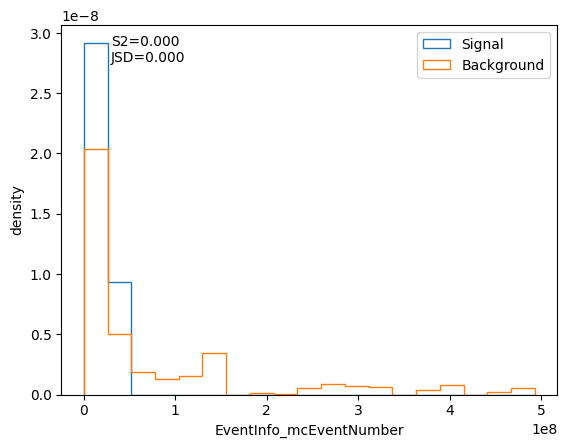

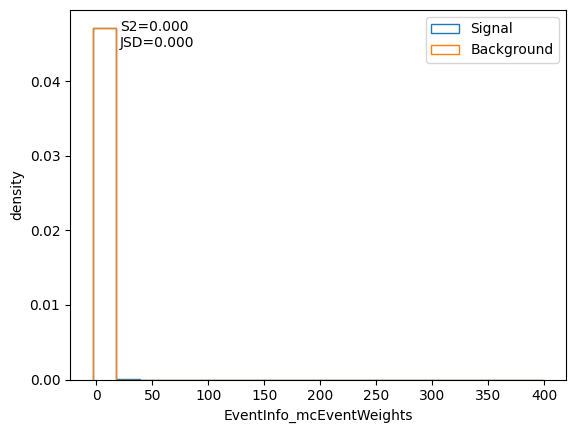

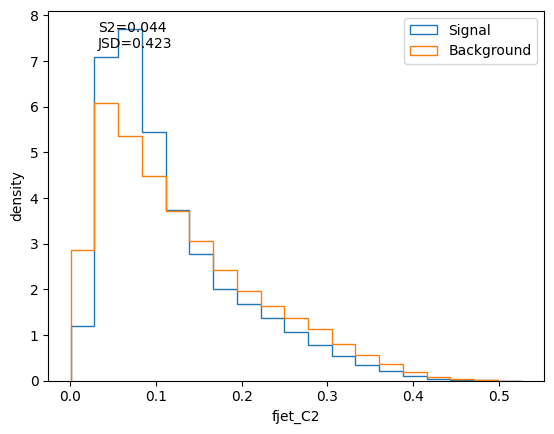

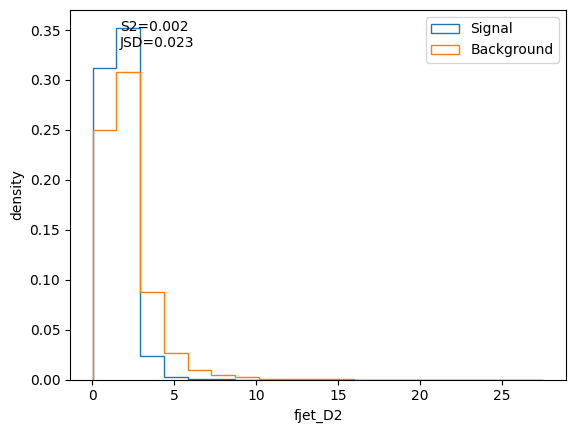

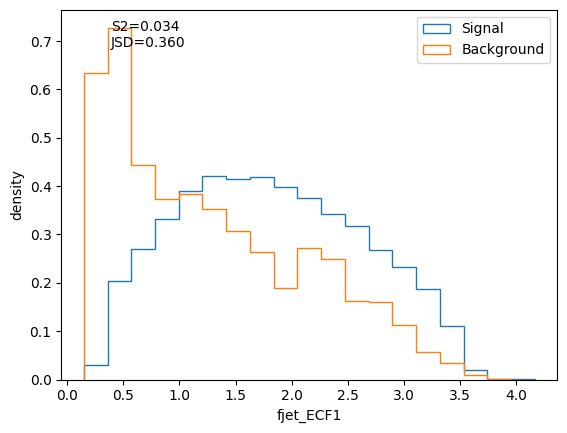

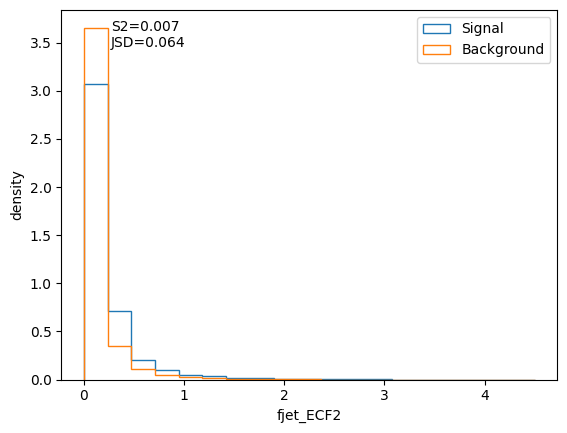

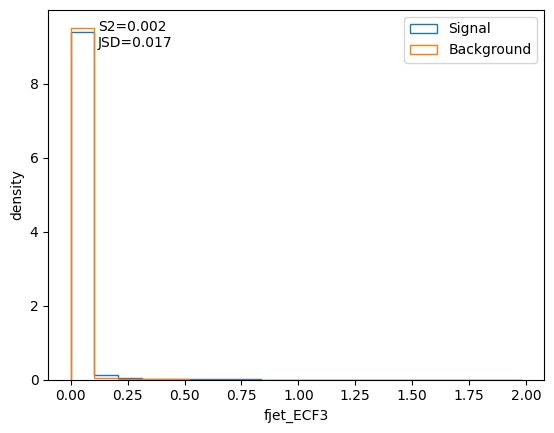

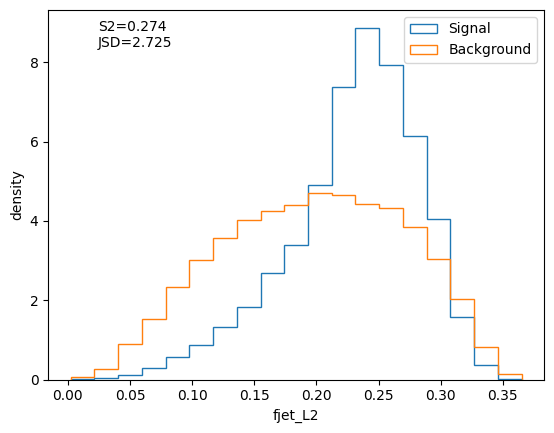

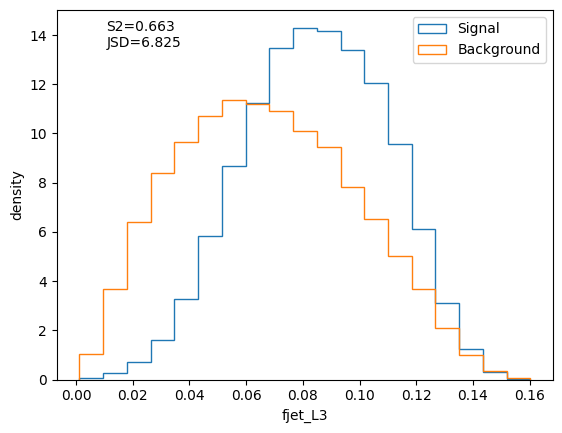

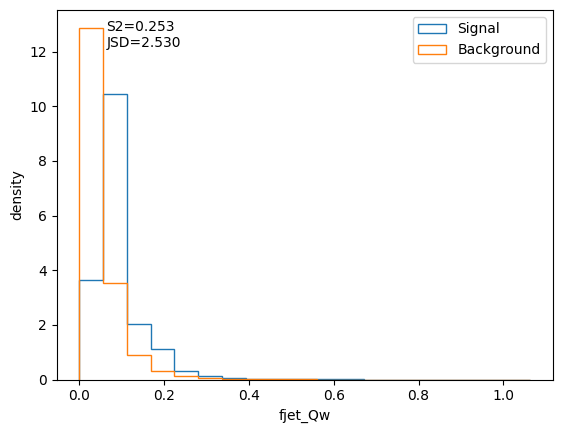

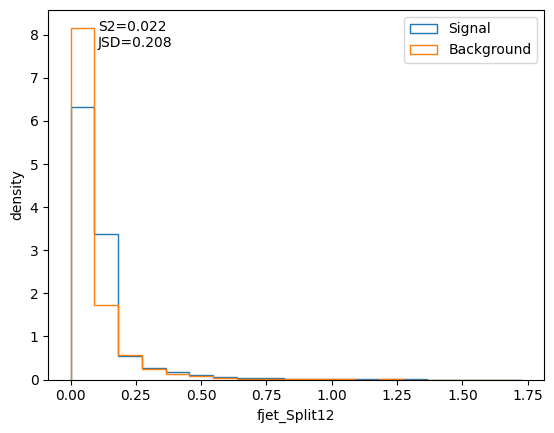

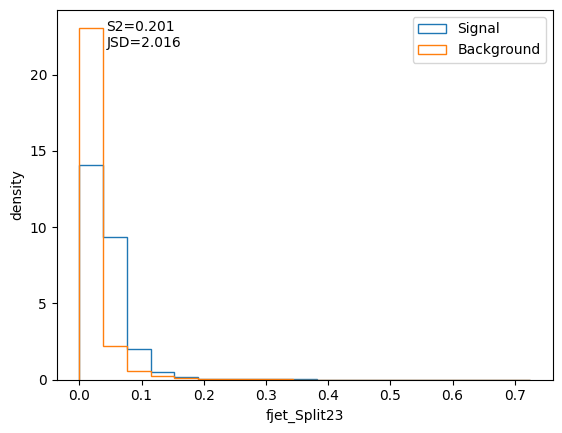

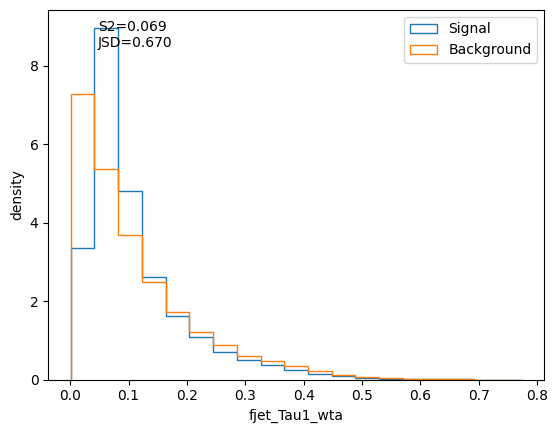

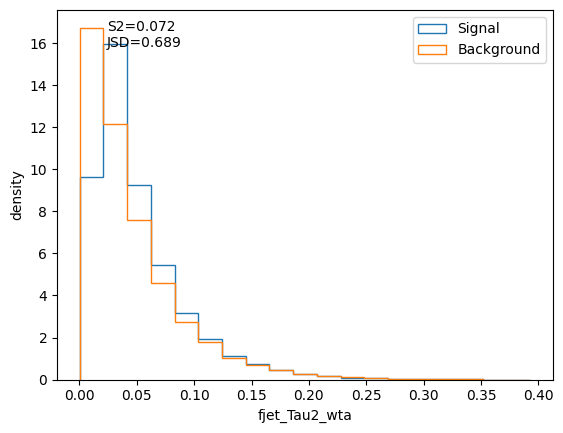

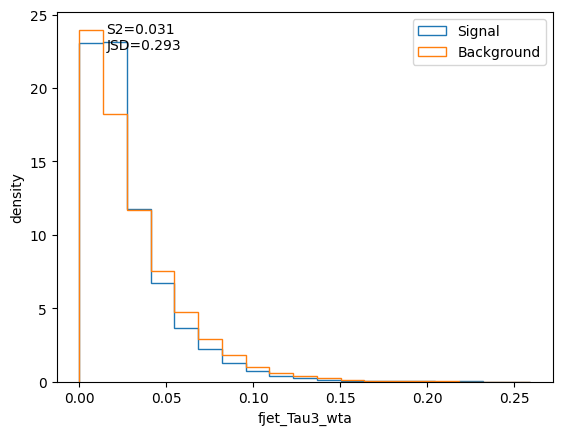

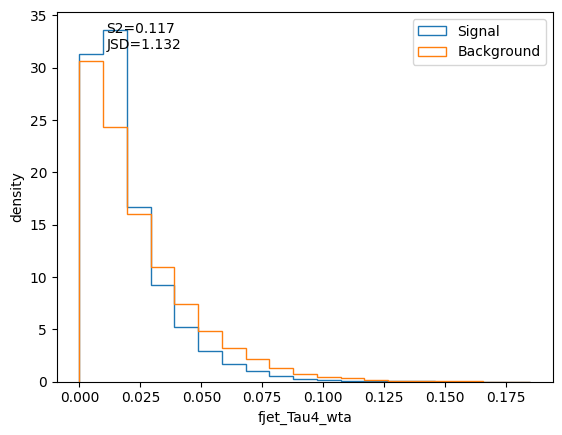

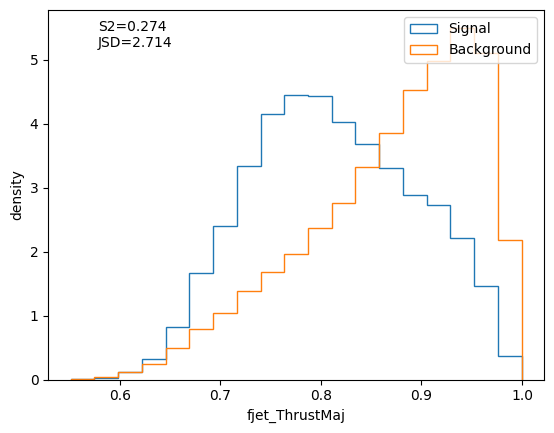

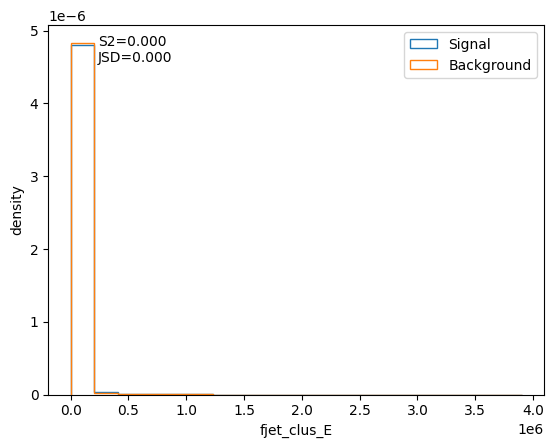

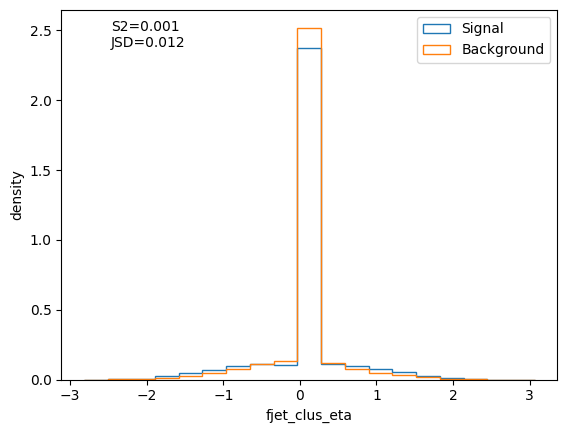

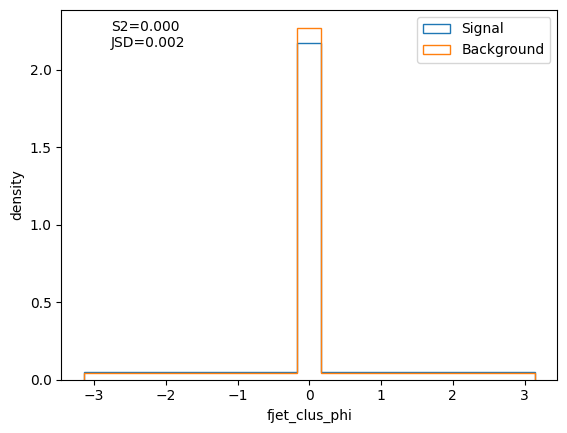

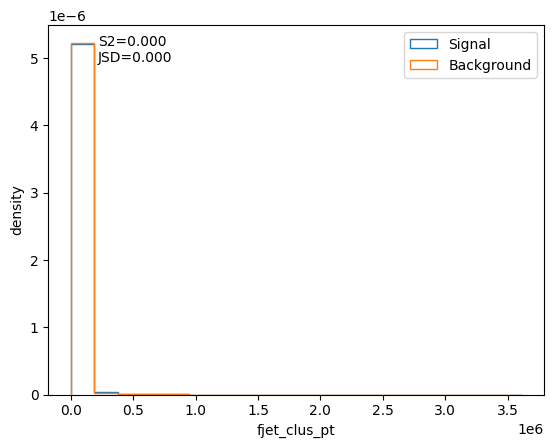

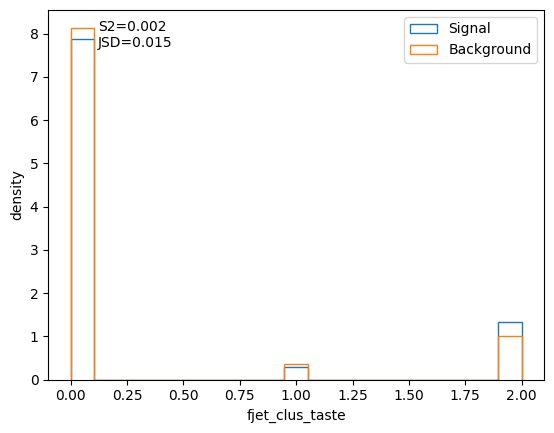

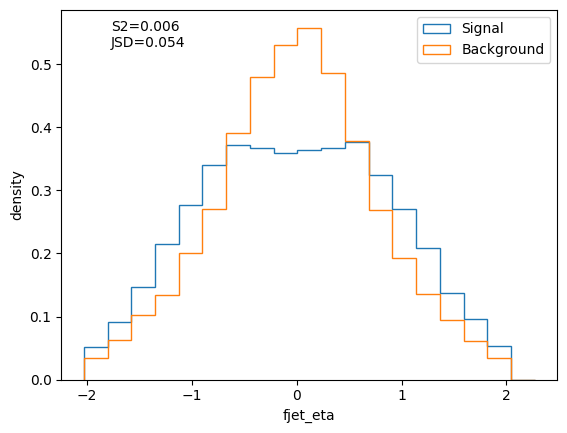

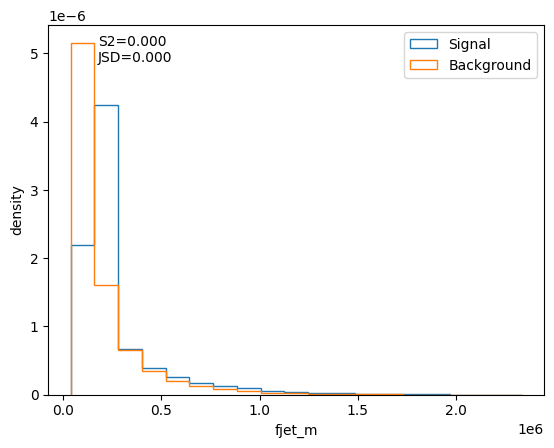

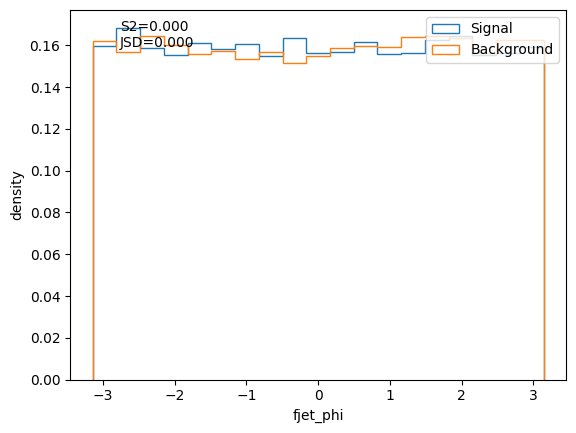

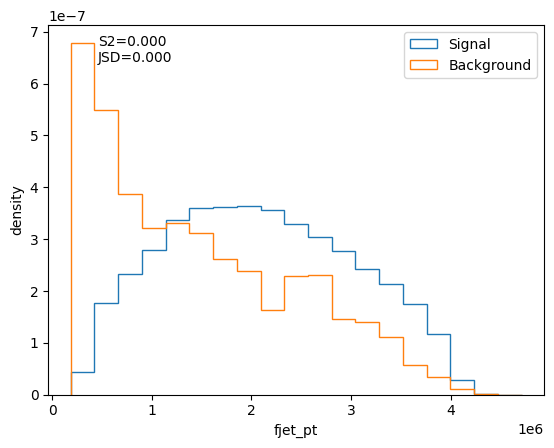

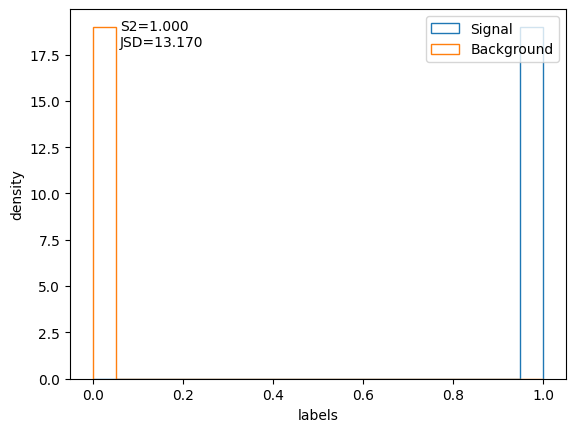

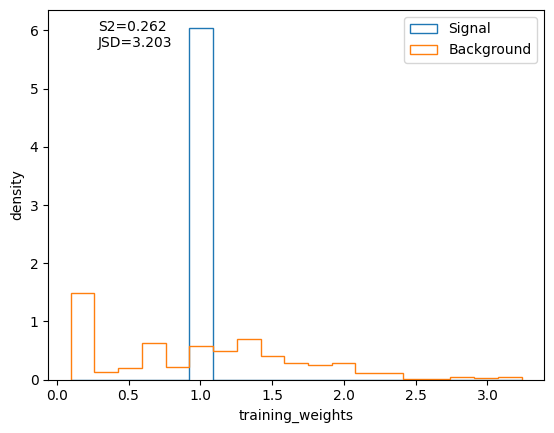

In [15]:
for var in f.keys():
    print(var)
    values_sig=[]
    values_bkg=[]
    for index,label in enumerate(labels):
        if label==1:
            values_sig.append(f[var][index])
        if label==0:
            values_bkg.append(f[var][index])
    values_sig=np.asarray(values_sig).flatten()
    values_bkg=np.asarray(values_bkg).flatten()
    make_hist(values_sig, values_bkg, var)

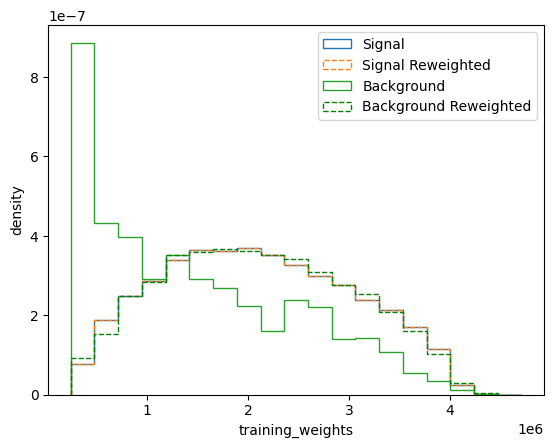

In [25]:
'''
values_sig=[]
values_bkg=[]
weights_sig=[]
weights_bkg=[]

for index,label in enumerate(labels):
    if label==1:
        values_sig.append(f["fjet_pt"][index])
        weights_sig.append(f["training_weights"][index])
    if label==0:
        values_bkg.append(f["fjet_pt"][index])
        weights_bkg.append(f["training_weights"][index])
values_sig=np.asarray(values_sig).flatten()
values_bkg=np.asarray(values_bkg).flatten()
weights_sig=np.asarray(weights_sig).flatten()
weights_bkg=np.asarray(weights_bkg).flatten()
'''
fig, ax = plt.subplots()
bins=np.linspace(min(values_sig),max(values_sig),20)
ax.hist(values_sig,bins=bins,histtype="step",density=True,label='Signal',edgecolor='yellow')
ax.hist(values_sig,bins=bins,histtype="step",density=True,label='Signal Reweighted',edgecolor='yellow',weights=weights_sig,linestyle='--')
ax.hist(values_bkg,bins=bins,histtype="step",density=True,label='Background',edgecolor='yellow')
ax.hist(values_bkg,bins=bins,histtype="step",density=True,label='Background Reweighted',edgecolor='green',weights=weights_bkg,linestyle='--')
plt.xlabel(name)
plt.ylabel('density')
plt.legend()